In [5]:
#model definition

import torch
from torch import nn
import torchvision
import copy

import lightly
from lightly.data import LightlyDataset
from lightly.data import MoCoCollateFunction
from lightly.loss import NTXentLoss
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum
from sklearn.preprocessing import normalize

In [6]:
resnet_features = 100
moco_hidden_features = 512
moco_projection_features = 128

class MoCo(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = MoCoProjectionHead(resnet_features, moco_hidden_features, moco_projection_features)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        query = self.backbone(x).flatten(start_dim=1)
        query = self.projection_head(query)
        return query

    def forward_momentum(self, x):
        key = self.backbone_momentum(x).flatten(start_dim=1)
        key = self.projection_head_momentum(key).detach()
        return key



In [7]:


resnet = torchvision.models.resnet18(num_classes = resnet_features)
"""
module_list = list(resnet.children())[:-1] + [nn.Linear(in_features=512, out_features=resnet_features,bias=False)]
backbone = nn.Sequential(*module_list)
"""
backbone = resnet
model = MoCo(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

MoCo(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [8]:
module_list = list(resnet.children())[:-1] + [nn.Linear(in_features=512, out_features=resnet_features,bias=False)]
print(nn.Sequential(*module_list))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [9]:
input_size = 32

collate_fn = MoCoCollateFunction(input_size=input_size)

cifar10_train = torchvision.datasets.CIFAR10("data/cifar10", download=True)
dataset_train = LightlyDataset.from_torch_dataset(cifar10_train)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")



dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)


test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

cifar10_test = torchvision.datasets.CIFAR10("data/cifar10", download=True, transform=test_transforms)
dataset_test = LightlyDataset.from_torch_dataset(cifar10_test,transform=test_transforms)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")



dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
criterion = NTXentLoss(memory_bank_size=4096)
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)


In [11]:
"""
print("Starting Training")
for epoch in range(20):
    total_loss = 0
    for (x_query, x_key), _, _ in dataloader_train:
        update_momentum(model.backbone, model.backbone_momentum, m=0.99)
        update_momentum(model.projection_head, model.projection_head_momentum, m=0.99)
        x_query = x_query.to(device)
        x_key = x_key.to(device)
        query = model(x_query)
        key = model.forward_momentum(x_key)
        loss = criterion(query, key)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader_train)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
"""

'\nprint("Starting Training")\nfor epoch in range(20):\n    total_loss = 0\n    for (x_query, x_key), _, _ in dataloader_train:\n        update_momentum(model.backbone, model.backbone_momentum, m=0.99)\n        update_momentum(model.projection_head, model.projection_head_momentum, m=0.99)\n        x_query = x_query.to(device)\n        x_key = x_key.to(device)\n        query = model(x_query)\n        key = model.forward_momentum(x_key)\n        loss = criterion(query, key)\n        total_loss += loss.detach()\n        loss.backward()\n        optimizer.step()\n        optimizer.zero_grad()\n    avg_loss = total_loss / len(dataloader_train)\n    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")\n'

In [12]:
"""
pretrained_resnet_backbone = model.backbone

state_dict = {
    'resnet18_parameters': pretrained_resnet_backbone.state_dict()
}
torch.save(state_dict, 'models/pretrained_resnet_backbone.pth')
"""

"\npretrained_resnet_backbone = model.backbone\n\nstate_dict = {\n    'resnet18_parameters': pretrained_resnet_backbone.state_dict()\n}\ntorch.save(state_dict, 'models/pretrained_resnet_backbone.pth')\n"

In [16]:
"""
# load the model in a new file for inference
resnet18_new = torchvision.models.resnet18()

# note that we need to create exactly the same backbone in order to load the weights
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1])
"""
backbone_new = resnet

ckpt = torch.load('models/pretrained_resnet_backbone.pth')
backbone_new.load_state_dict(ckpt['resnet18_parameters'])

model.backbone = backbone_new


In [17]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    labels = []
    with torch.no_grad():
        for img, label, _ in dataloader:
            img = img.to(device)
            emb = model.backbone(img).flatten(start_dim=1).cpu()
            embeddings.append(emb)
            labels.extend(label)


    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, labels

model.eval()
embeddings, labels = generate_embeddings(model, dataloader_test)
labels = [l.item() for l in labels]

In [18]:
from sklearn.manifold import TSNE
embeddings_tsne_3d = TSNE(n_components=3).fit_transform(embeddings)
embeddings_tsne_2d = TSNE(n_components=2).fit_transform(embeddings)

/home/jovyan/test_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/test_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jovyan/test_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/test_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


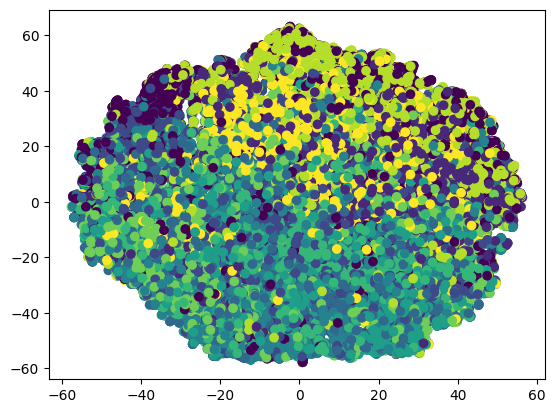

In [19]:
import matplotlib.pyplot as plt
plt.scatter([e[0] for e in embeddings_tsne_2d],
            [e[1] for e in embeddings_tsne_2d],
            c=labels)

In [20]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

fig = go.Figure(data=[go.Scatter3d(
    x=[a[0] for a in embeddings_tsne_3d], # ie [0, 1, 2, 3]
    y=[a[1] for a in embeddings_tsne_3d], # ie [0, 1, 2, 3]
    z=[a[2] for a in embeddings_tsne_3d], # ie [0, 1, 2, 3]
    hovertemplate='<b>%{text}</b><extra></extra>',
    text = labels,
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.8,
        color=labels,
    )
)])

fig.show()


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier

tabpfn_trainsize = 14

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=tabpfn_trainsize, random_state=42, stratify=labels)



# N_ensemble_configurations controls the number of model predictions that are ensembled with feature and class rotations (See our work for details).
# When N_ensemble_configurations > #features * #classes, no further averaging is applied.

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Using style prior: True
Using cpu device
Using a Transformer with 25.82 M parameters


: 

: 

In [ ]:
X_train